### The highest private LB script (#13) on the forum, by tks.  This makes me feel very silly indeed, as it performs  no feature engineering and yet does very well!  

### tks took a real gamble working on an approach that had a bad public LB score, and it paid off.  (but... I don't quite understand just how he got here.)

In [1]:
import kagglegym
import numpy as np
import pandas as pd
import xgboost as xgb

env = kagglegym.make()
o = env.reset()

excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in o.train.columns if c not in excl] # note: no feature engineering *at all*

# only keep (groups of) days with low y mean
roll_std = o.train.groupby('timestamp').y.mean().rolling(window=10).std().fillna(0)
train_idx = o.train.timestamp.isin(roll_std[roll_std < 0.009].index)

y_train = o.train['y'][train_idx]
xgmat_train = xgb.DMatrix(o.train.loc[train_idx, cols], label=y_train)

# exp070
params_xgb = {'objective'        : 'reg:linear',
              'tree_method'      : 'hist',  # relatively new addition to xgboost - I hadn't thought of using it!
              'grow_policy'      : 'depthwise',
              'eta'              : 0.05,
              'subsample'        : 0.6,
              'max_depth'        : 10,
              'min_child_weight' : y_train.size/2000,
              'colsample_bytree' : 1, 
              'base_score'       : y_train.mean(),
              'silent'           : True,
}
n_round = 16 # far shorter than any model I used, with more depth...

bst_lst = []
for i in range(8):
    params_xgb['seed'] = 2429 + 513 * i
    bst_lst.append(xgb.train(params_xgb,
                             xgmat_train,
                             num_boost_round=n_round,
                             # __copy__ reduce memory consumption?
                             verbose_eval=False).__copy__())

while True:
    pr_lst = []
    xgmat_test = xgb.DMatrix(o.features[cols])
    for bst in bst_lst:
        pr_lst.append(bst.predict(xgmat_test))

    pred = o.target
    pred['y'] = np.array(pr_lst).mean(0)
    o, reward, done, info = env.step(pred)
    if done:
        print(info)
        break
    if o.features.timestamp[0] % 100 == 0:
        print(reward)


-0.312268736988
-0.186031887008
-0.162717352616
0.00486516087517
-0.119639391389
-0.169665408
-0.183694318891
-0.314360678298
-0.00499440747557
{'public_score': 0.028008661473639181}


### Get feature importance of all 8 models

In [29]:
df_fsl = []
for b in bst_lst:
    fs = b.get_fscore()
    df_fsl.append(pd.DataFrame(fs, index=[len(df_fsl)]))
    
df_fs = pd.concat(df_fsl)

# add a summation (this will be index 8)
df_fs.loc[len(df_fs)] = df_fs.sum()

In [30]:
df_fs.transpose().sort_values(8, ascending=False)

,0,1,2,3,4,5,6,7,8
technical_30,75.0,67.0,68.0,72.0,68.0,76.0,76.0,62.0,564.0
technical_20,56.0,52.0,48.0,59.0,57.0,58.0,48.0,54.0,432.0
technical_21,51.0,45.0,46.0,35.0,38.0,54.0,56.0,36.0,361.0
technical_17,34.0,34.0,52.0,34.0,44.0,31.0,30.0,30.0,289.0
technical_19,44.0,38.0,26.0,34.0,32.0,35.0,36.0,26.0,271.0
technical_40,32.0,33.0,30.0,39.0,31.0,34.0,33.0,37.0,269.0
technical_41,25.0,37.0,35.0,23.0,30.0,32.0,43.0,29.0,254.0
technical_2,26.0,34.0,32.0,24.0,35.0,24.0,27.0,32.0,234.0
technical_3,25.0,35.0,24.0,28.0,30.0,31.0,38.0,16.0,227.0
technical_24,28.0,27.0,32.0,20.0,26.0,33.0,29.0,29.0,224.0


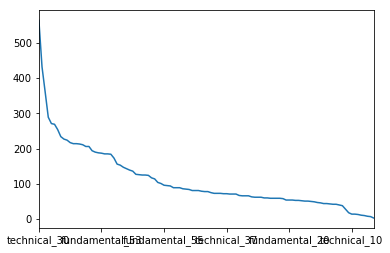

In [34]:
df_fs.loc[8].sort_values(ascending=False).plot()

In [37]:
df_fs.loc[0:7].std().sort_values(ascending=False)

technical_21      8.184262
technical_17      7.827379
technical_3       6.864765
technical_41      6.519202
fundamental_53    6.300510
technical_43      6.197638
fundamental_41    6.093029
technical_19      6.010408
derived_0         5.631544
technical_25      5.496752
technical_0       5.356905
fundamental_44    5.208167
technical_30      5.070926
fundamental_21    4.832923
technical_5       4.832923
technical_36      4.743416
technical_6       4.657943
fundamental_29    4.642582
technical_2       4.496030
technical_31      4.470139
technical_20      4.309458
technical_27      4.301163
fundamental_25    4.290771
fundamental_23    4.240536
technical_28      4.155461
technical_12      4.155461
technical_1       4.070802
fundamental_10    4.070802
technical_24      4.000000
fundamental_56    3.777282
                    ...   
fundamental_31    2.288689
fundamental_62    2.267787
fundamental_3     2.263846
fundamental_0     2.251983
fundamental_46    2.232071
technical_14      2.199838
t